In [1]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re

from structure_tools.Modules_tools import return_fsts

PCA_color_ref= ['darkseagreen','crimson', 'darkorange', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink']

### .vcf analysis

Jupyter notebook for the local analysis of genetic data stored in `.vcf` format.

Perform analysis of structure across data set, followed by a more detailed study of variation across local genomic windows.

This particular notebook constitutes a case study of rice (*Oryza sativa*) genetic variation across a single chromosome. Data was extracted from the 3K RG data set (Mansueto *et al*. 2017) and filtered for missing data (< 0.001 % per SNP). One accession was removed for excess missing data. A subset of 15 thousand loci was then sampled randomly from chromosome 8 and converted to .vcf format (see [Upstream pre-process](https://github.com/SantosJGND/Galaxy_KDE_classifier/tree/master/Upstream_process)). 

### Index:

**A. Input**

>i. Read vcf data and passport information of accessions within. 

>ii. Sample loci and accessions for a smaller data set. 

**B. Global structure analysis.**

>i. Perform PCA and Mean Shift.

>ii. Visualize structure. Decide wheather to use Mean Shift results or input classes going further.

**C. Window sub-divide. Exploratory analysis of local structure.**

>i. Chose window size (in SNPs) and distance between windows. Windows overlap if Steps < Window_length.

>ii. Initial exploration step: visualize structure at subset of randomly selected windows.

>iii. Study differentiation between reference populations across range of local windows. 

**D. Supervised classification.**

>i. Chose reference groups, perform kernel density estimation across windows, extract p-values.

>ii. Study classification patterns across windows. Alows intermediate and outlier classes.

**E. Mean Shift cluster Analysis**

>i. Perform mean shift clustering across windows.

>ii. Perform dimensionality reduction and clustering of local cluster profiles.

>iii. Study relation between local cluster groups and global structure.

>iv. Plot significance to local clusters by cluster group factor. 



### Reference

- Mansueto, et al. Rice SNP-seek database update: new SNPs, indels, and queries.Nucl. Acids Res.(2017) 45 (D1): D1075-D1081. doi: 10.1093/nar/gkw1135 This paper describes new features and datasets added to SNP-Seek in 2015-2017 as well as software and database updates.

### A. Input

#### i. Read vcf, read passport data

In [2]:

def read_geno_nanum(filename, row_info= 6,header_info= 9,phased= False):

    info_summ= {}
    info_save= list(range(row_info))

    header_len= header_info
    summary= []

    Miss= recursively_default_dict()
    
    Input= open(filename,'r')

    genotype= []
    d= 0

    for line in Input:    
        line= line.strip().split()
        
        if line[0] != "#CHROM" and d == 0:
            continue

        if line[0] == "#CHROM":
            #print(info_summ)
            line= '\t'.join(line)
            line= ''.join(filter(lambda ch: ch not in "#", line))
            line= line.split()
            
            columns= line[:header_len]
            Names= line[header_len:]
            d += 1
            continue

        if d > 0:
            #line= line.split()
            seq= []
            #print(line)
            info= line[:header_len]
            chrom= re.search(r'\d+', line[0]).group()
            info[0]= chrom
            #print(chrom)

            summary.append(info)
            #print(chrom)
            #print(line)
            
            for ind in range(header_len,len(line)):
                
                locus= line[ind]
                #print(locus)
                alleles= locus.split(':')[0]
                
                #print(alleles)
                
                if '.' in alleles:
                    alleles= ''.join([[x,'0'][int(x == '.')] for x in list(alleles)])
                alleles= list(map(int, re.findall(r'\d+', alleles)))
                if len(alleles) != 2:
                    print(alleles)
                if phased:
                    seq.extend(alleles)
                else:
                    seq.append(sum(alleles))

            genotype.append(seq)
            d += 1

    Input.close()

    summary= np.array(summary)
    summary= pd.DataFrame(summary,columns= columns)
    genotype= np.array(genotype).T

    return genotype, summary, Names



In [3]:
#from structure_tools.vcf_geno_tools import read_geno_nanum

Home= 'vcf/'
Chr= 8
filename= Home + 'chr8.3000000-4000000.pops_filtered.vcf'

row_info= 6
header_info= 9
phased= False

genotype, summary, Names= read_geno_nanum(filename, row_info= row_info, header_info= header_info,phased= phased)

print('Number of markers: {}'.format(genotype.shape[1]))
print('Number of individuals: {}'.format(genotype.shape[0]))


Number of markers: 21904
Number of individuals: 81


In [4]:
## read passport information

Input_file= 'ind_assignments.txt'

RG_info= pd.read_csv(Input_file,sep= '\t',header= None)
RG_info.columns=  ['ID','sbsps']
RG_info.head()

ID        sbsps
0  C_rhe_1  tcheliensis
1  C_rhe_2  tcheliensis
2  C_rhe_3  tcheliensis
3  C_rhe_4  tcheliensis
4  C_rhe_5  tcheliensis

#### ii. Subset accessions and SNPs

Chose *Sn* and *Sm* for individual and marker number. Indexes will be selected randomly. 

*This step will allow for an input file for selection in the near future*

In [39]:
list(set(RG_info.sbsps))

['brevicaudus', 'CH', 'mulatta', 'tcheliensis', 'littoralis', 'lasiotis']

In [5]:
from structure_tools.vcf_geno_tools import geno_subset_random

Sn= 81 ### accession random filter
Sm= 20000 ### snp random filter

ID_col= 'ID'
subset_col= 'sbsps'

code= {
    'brevicaudus':0,
    'CH':1,
    'mulatta':2,
    'tcheliensis':3,
    'littoralis':4,
    'lasiotis':5
}


others= 'admx'

#gen_sample, subsummary, code_vec, code_lib, Nsample, Msample

gen_sample, subsummary, code_vec, code_lib, Nsample, Msample= geno_subset_random(genotype,summary, RG_info, ID_col,subset_col, Names,code=code, Sn= Sn, Sm= Sm)

color_groups= ['red','yellow','blue','green','purple','black','silver','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']



gen_sample shape: 81, 20000


### B. Global variation

#### i. PCA

Perform PCA across data set.

Perform Mean shift clustering to attempt to extract genetically coherent groups of accessions.

These can later be used for supervised analysis.

In [6]:
## Perform PCA
n_comp= 5
pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')

feats= pca.fit_transform(gen_sample)


## perform MeanShift clustering.
bandwidth = estimate_bandwidth(feats, quantile=0.15)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=True, min_bin_freq=15)
ms.fit(feats)
labels1 = ms.labels_
label_select = {y:[x for x in range(len(labels1)) if labels1[x] == y] for y in sorted(list(set(labels1)))}


#### ii. Structure and classification

Analyse structure in data set as conveyed by PCA. 

In [7]:
###
from structure_tools.Tutorial_subplots import plot_global_classes


plot_global_classes(feats,
                    code_lib,
                    label_select,
                    color_groups,
                    PCA_color_ref,
                    title_I= 'IRRI class',
                    title_II= 'Mean_shift',height= 900, width= 950)


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



### iii. Select factor 

The analyses below will be informed by the distributions of groups of accessions. Chose wheather to analyse using the clustering performed here, or that provided in the input passport file. 

*Come back to this step to repeat analyses with a different set of labels.*

In [11]:
references= ['Local','External']

chose_refs= 1

ref_chosen= references[chose_refs]

if ref_chosen== 'Local':
    ref_dict= label_select
    ref_vector= labels1

if ref_chosen== 'External':
    ref_dict= code_lib
    ref_vector= code_vec

In [33]:
[len(x) for x in ref_dict.values()]

[5, 2, 10, 5, 28, 31]

### C. Local Analysis

Analyse genetic variation across genomic windows. Begin by chosing the size of each window (`window_size`) and the distance between windows (in number of markers, `Steps`).

In [12]:
from structure_tools.vcf_geno_tools import geno_window_split
##### 
window_size= 215

Steps= 10

Windows, Out= geno_window_split(gen_sample,
                                subsummary,
                                Steps= Steps,
                                window_size=window_size)

print('number of chromosomes: {}'.format(len(Windows)))
print('number of windows: {}'.format(sum([len(Windows[x].keys()) for x in Windows.keys()])))


number of chromosomes: 1
number of windows: 1980


#### i. Local variation sample

Visualize genetic structure at local windows using PCA. Plot colors will correspond to the Mean shift clustering above. 

Use the list `plot_who` to plot only accessions from specific groups.

Use the list `shade` to lower the opacity of samples from specific groups.

In [44]:
## a look at local windows
from structure_tools.Tutorial_subplots import window_sample_plot

windows_pick= 5
Chr= Chr

plot_who= [0,2,4]
shade= []


window_sample_plot(Windows,
                   ref_dict,
                   color_groups,
                   plot_who= plot_who,
                   shade= shade,
                   Chr= Chr,
                   windows_pick= windows_pick,
                   height= 1000,width= 900)

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]  
[ (2,1) x3,y3 ]    [ (2,2) x4,y4 ]  
[ (3,1) x5,y5 ]    [ (3,2) x6,y6 ]  
[ (4,1) x7,y7 ]    [ (4,2) x8,y8 ]  
[ (5,1) x9,y9 ]    [ (5,2) x10,y10 ]



#### iii. Variation across windows.

>*i. Chose a range of windows, or a number of windows to be sampled randomly.*

>*ii. Perform PCA, AMOVA and allele frequency extraction at each window*

Analyses can be performed in either a supervised or an unsupervised manner.
For supervised analyses, use the labels from the Meanshift analysis above to chose reference labels. If the argument `include_who` is provided (list), analyses will be perform using only samples from the groups identified in that list.

>*ii. Analyse genetic distance between reference or unsupervised groups at selected windows.*

>*iii. Analyze principal component analysis projection along 1st PC across windows selected.*



In [56]:
from structure_tools.Modules_tools import return_fsts2
from structure_tools.vcf_geno_tools import window_fst_sup

ref_labels= [0,4,5]

fst_range= [0,len(Windows[Chr])]

Fst_window= window_fst_sup(Windows,
                         ref_labels,
                         ref_vector,
                         Chr= Chr,
                         ncomp= 4,
                        range_sample= fst_range)


D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools.py:136: RuntimeWarning:

invalid value encountered in double_scalars

D:\GitHub\Tools_and_toys\VCF_analysis\Subset_explore\structure_tools\Modules_tools

In [57]:
from structure_tools.vcf_geno_tools import window_analysis
from IPython.display import clear_output
from structure_tools.AMOVA_func import AMOVA_FM42, amova_cofactor

include_who= [2,4]
pc_range= [0,150]

PC_sel= 1

Frequencies, sim_fst, Results, Construct, pc_density, pc_coords, fst_fig= window_analysis(Windows,
                                                                                 ref_labels,
                                                                                 ref_vector,
                                                                                 Chr= Chr,
                                                                                 ncomp= 4,
                                                                                 amova= True,
                                                                                 supervised= True,
                                                                                 include_who= include_who,
                                                                                 range_sample= pc_range,
                                                                                 rand_sample= 0,
                                                                                 clsize= 15,
                                                                                 cl_freqs= 5,
                                                                                 Bandwidth_split= 20,
                                                                                 quantile= .2,
                                                                                 centre_d= True,
                                                                                 PC_sel= PC_sel - 1)



counting: -0.1331568566313307, Ngps: 2


In [58]:
Results['info'].head()

chrom     window     AMOVA  Ngps
0    8.0  3014683.0 -0.126840   2.0
1    8.0  3015020.0 -0.131783   2.0
2    8.0  3015647.0 -0.134521   2.0
3    8.0  3015937.0 -0.132108   2.0
4    8.0  3016325.0 -0.129308   2.0

### AMOVA

- Density plot

In [59]:
AMOVA_winds= Results['info'].AMOVA

X_plot = np.linspace(0, 1, 100)

freq_kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(np.array(AMOVA_winds).reshape(-1,1))

log_dens = freq_kde.score_samples(X_plot.reshape(-1,1))

fig_AMOVA_dens= [go.Scatter(x=X_plot, y=np.exp(log_dens), 
                            mode='lines', fill='tozeroy', name= '',
                            line=dict(color='blue', width=2))]
##

layout= go.Layout(
    title= 'AMOVA across windows - density',
    height= 300,
    width= 900,
    yaxis= dict(
        title= 'density'
    ),
    xaxis= dict(
        title= 'AMOVA'
    )
)

fig = go.Figure(data=fig_AMOVA_dens, layout= layout)

iplot(fig)

- AMOVA *x* windows

In [60]:
fig_genAMOVA= [go.Scatter(
    x= list(range(fst_range[0],fst_range[1])),
    y= AMOVA_winds,
    line= dict(width= 10)
)]

layout_genam= go.Layout(
    title= 'AMOVA along chrom.',
    yaxis= dict(
        range= [0,.15]
    )
)

fig = go.Figure(data=fig_genAMOVA, layout= layout_genam)
fig['layout'].update(height= 400,width= 900)

iplot(fig)

### **ii.** Fst across data sets

- Density plot

In [63]:

iplot(fst_fig)

In [64]:
from scipy import stats
print('fst mean: {}, sd: {}'.format(*[round(x,3) for x in [np.mean(sim_fst),np.std(sim_fst)]]))

stats.norm.interval(0.95, loc=np.mean(sim_fst), scale=np.std(sim_fst))

fst mean: 0.018, sd: 0.003


(0.01216577068524418, 0.024349275933950275)

- **a. Fst between selected reference groups across data set range.**

In [65]:
from structure_tools.Tutorial_subplots import fst_window_plot


fst_window_plot(Fst_window,ref_labels,sort= False,window_range= fst_range,y_range= [0,.35],height= 350,width= 950)

- **b. PC sample distribution across data sets queried.**

In [66]:
from structure_tools.Tutorial_subplots import PC_analysis_plot

labels_code= ref_vector

if include_who:
    labels_code= [x for x in labels_code if x in include_who]

## plot_choices: ['coords','density']
PC_plot= PC_analysis_plot(pc_density,pc_coords,labels_code,color_groups,range_windows= pc_range,
                 plot_choice= 'coords',height= 400,width= 1000,y_range= [-7,12],qtl= .99,PC_sel= PC_sel)

iplot(PC_plot)

In [67]:
dict_coords= {}
Windows_range_pca= [100,320]
PC_sel= 1

who_single= [0,2]

for access in who_single:
    include_who= [access]


    Frequencies, sim_fst, Results, Construct, pc_density_s, pc_coords_s, fst_fig= window_analysis(Windows,
                                                                                     ref_labels,
                                                                                     ref_vector,
                                                                                     Chr= Chr,
                                                                                     ncomp= 4,
                                                                                     amova= False,
                                                                                     supervised= True,
                                                                                     include_who= include_who,
                                                                                     range_sample= Windows_range_pca,
                                                                                     rand_sample= 0,
                                                                                     clsize= 15,
                                                                                     cl_freqs= 5,
                                                                                     Bandwidth_split= 20,
                                                                                     quantile= .4,
                                                                                     centre_d= True,
                                                                                     PC_sel= PC_sel - 1)
    
    labels_code_s= ref_vector

    if include_who:
        labels_code_s= [x for x in labels_code_s if x in include_who]
    
    dict_coords[access]= {
        'coords': pc_coords_s,
        'dens': pc_density_s,
        'labs': labels_code_s
    }



In [68]:
dict_coords.keys()

dict_keys([0, 2])

In [69]:
from plotly import tools

PC_selection= [PC_sel]*len(who_single)
titles= ['Gp{}; PC{}; range: {}'.format(who_single[x],PC_selection[x],'-'.join([str(x) for x in Windows_range_pca])) for x in range(len(who_single))]
Ncols= 1
print(titles)

fig_subplots = tools.make_subplots(rows= len(titles), cols=Ncols,
                         subplot_titles=tuple(titles))

for gp in range(len(titles)):

    pos1= gp + 1
    pos2= 1
    
    who= who_single[gp]
    
    title= titles[gp]


    fig= PC_analysis_plot(dict_coords[who]['dens'],dict_coords[who]['coords'],dict_coords[who]['labs'],color_groups,range_windows= Windows_range_pca,
                     plot_choice= 'coords',height= 400,width= 1000,y_range= [-9,12],qtl= .99,PC_sel= PC_selection[gp])
    
    for trace1 in fig['data']:

        fig_subplots.append_trace(trace1, pos1, pos2)


    fig_subplots['layout']['yaxis' + str(gp + 1)].update(title=fig['layout']['yaxis']['title'])

    fig_subplots['layout']['xaxis' + str(gp + 1)].update(title=fig['layout']['xaxis']['title'])



fig_subplots['layout'].update(height= 700,width= 900)
iplot(fig_subplots)


['Gp0; PC1; range: 100-320', 'Gp2; PC1; range: 100-320']
This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]

220
(220, 2)
220
(220, 2)


### One population across components


In [70]:
dict_coords= {}
Windows_range_pca= [400,550]

group_list= [2,2]
PC_selection= [1,2]

for access in range(len(group_list)):
    include_who= [group_list[access]]
    
    


    Frequencies, sim_fst, Results, Construct, pc_density_s, pc_coords_s, fst_fig= window_analysis(Windows,
                                                                                     ref_labels,
                                                                                     ref_vector,
                                                                                     Chr= Chr,
                                                                                     ncomp= 4,
                                                                                     amova= False,
                                                                                     supervised= True,
                                                                                     include_who= include_who,
                                                                                     range_sample= Windows_range_pca,
                                                                                     rand_sample= 0,
                                                                                     clsize= 15,
                                                                                     cl_freqs= 5,
                                                                                     Bandwidth_split= 20,
                                                                                     quantile= .2,
                                                                                     centre_d= True,
                                                                                     PC_sel= PC_selection[access] - 1)
    
    labels_code_s= ref_vector

    if include_who:
        labels_code_s= [x for x in labels_code_s if x in include_who]
    
    dict_coords[access]= {
        'coords': pc_coords_s,
        'dens': pc_density_s,
        'labs': labels_code_s
    }



In [71]:
titles= ['Gp{}; PC{}; range: {}'.format(group_list[x],PC_selection[x],'-'.join([str(x) for x in Windows_range_pca])) for x in range(len(group_list))]
Ncols= 1
print(titles)

fig_subplots = tools.make_subplots(rows= len(titles), cols=Ncols,
                         subplot_titles=tuple(titles))

for gp in range(len(titles)):

    pos1= gp + 1
    pos2= 1
    
    include_who= [group_list[gp]]
    
    title= titles[gp]


    fig= PC_analysis_plot(dict_coords[gp]['dens'],dict_coords[gp]['coords'],dict_coords[gp]['labs'],color_groups,range_windows= Windows_range_pca,
                     plot_choice= 'coords',height= 400,width= 1000,y_range= [-9,12],qtl= .99,PC_sel= PC_selection[gp])
    
    for trace1 in fig['data']:

        fig_subplots.append_trace(trace1, pos1, pos2)


    fig_subplots['layout']['yaxis' + str(gp + 1)].update(title=fig['layout']['yaxis']['title'])

    fig_subplots['layout']['xaxis' + str(gp + 1)].update(title=fig['layout']['xaxis']['title'])



fig_subplots['layout'].update(height= 700,width= 900)
iplot(fig_subplots)


['Gp2; PC1; range: 400-550', 'Gp2; PC2; range: 400-550']
This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]

150
(150, 2)
150
(150, 2)


### Sound from amp

We will use the standard deviation of a single population across a given component as the amplitude of a audio signal.

First select the group, PC and range of local windows to use. We run the `window_analysis` function to extract centred PCA coordinates.



In [72]:
from structure_tools.vcf_geno_tools import get_sound_coords

group= 2
PC_select= 1
Windows_range_music= [200,320]

 
Frequencies, sim_fst, Results, Construct, pc_density_s, pc_coords_s, fst_fig= window_analysis(Windows,
                                                                                 ref_labels,
                                                                                 ref_vector,
                                                                                 Chr= Chr,
                                                                                 ncomp= 4,
                                                                                 amova= False,
                                                                                 supervised= True,
                                                                                 include_who= [group],
                                                                                 range_sample= Windows_range_music,
                                                                                 rand_sample= 0,
                                                                                 clsize= 15,
                                                                                 cl_freqs= 5,
                                                                                 Bandwidth_split= 20,
                                                                                 quantile= .2,
                                                                                 centre_d= True,
                                                                                 PC_sel= PC_select - 1)

#####
#####
#####


In [73]:
qtl= 0.95

sampleRate = 74100
frequency = 1500
length = 10

fig_test,y= get_sound_coords(pc_coords_s,sampleRate= sampleRate,
                                frequency= frequency,
                                length= length,
                                group= group,
                                PC_select= PC_select)


iplot(fig_test)

In [74]:
### Thank you to Allen B. Downey for the ThinkDSP book, 
### and for the code, so shamelessly used here.
### visit http://github.com/allendowney

import structure_tools.thinkdsp as thinkdsp

wave= thinkdsp.Wave(y,framerate=sampleRate)

wave.make_audio()


### D. Supervised classification across windows.

*Perform supervised classification of samples across local genomic windows using Kernel Density Estimation.*

Begin by performing the KDE of selected groups across windows and extracting sample *p*-values for each. 

The function `KDE_windows` allows for an outlier threshold and a *p*-value comparison threshold for ambiguous classifications.

KDE is run in the feature space of the PCA of local windows. Select the number of components to retain using `n_comps`.

In [80]:
### KDE analysis across windows
from structure_tools.Sim_ideogram_tools import Merge_class, extract_profiles, KDE_windows, KDE_window_profiles, return_ideogram

## Use result of MS classification.

ref_labels= [0,3,2]
kde_class_labels= ref_vector
n_comps= 4
Chr= 8

from IPython.display import clear_output

Windows_profiles, var_comp_store= KDE_window_profiles(Windows,ref_vector,ref_labels, Chr= Chr,n_comps= n_comps)

c:\users\floyd\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

c:\users\floyd\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

c:\users\floyd\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning:

The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.

c:\users\floyd\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning:

The default of the `iid` parameter will change from True to Fa

Select comparison and outlier thresholds for classification using `Comparison_threshold` and `Outlier_threshold`. Chose which groups to plot using `groups_plot`.

Plot classificaiton against genotype and genomic position. 

In [82]:
from structure_tools.Sim_ideogram_tools import compress_ideo, class_and_ideo


Comparison_threshold= 4
Outlier_threshold= 1e-5

colors= 'standard'
alt_col= PCA_color_ref

groups_plot=[0,3,2]

ideo_kde, ideo_kde, chromosome_list = class_and_ideo(Windows_profiles,Out,ref_vector,
                         Comparison_threshold= Comparison_threshold,
                         Outlier_threshold= Outlier_threshold,
                         groups_plot=groups_plot,
                         colors= 'standard',
                         alt_col= alt_col)


adding ideograms...


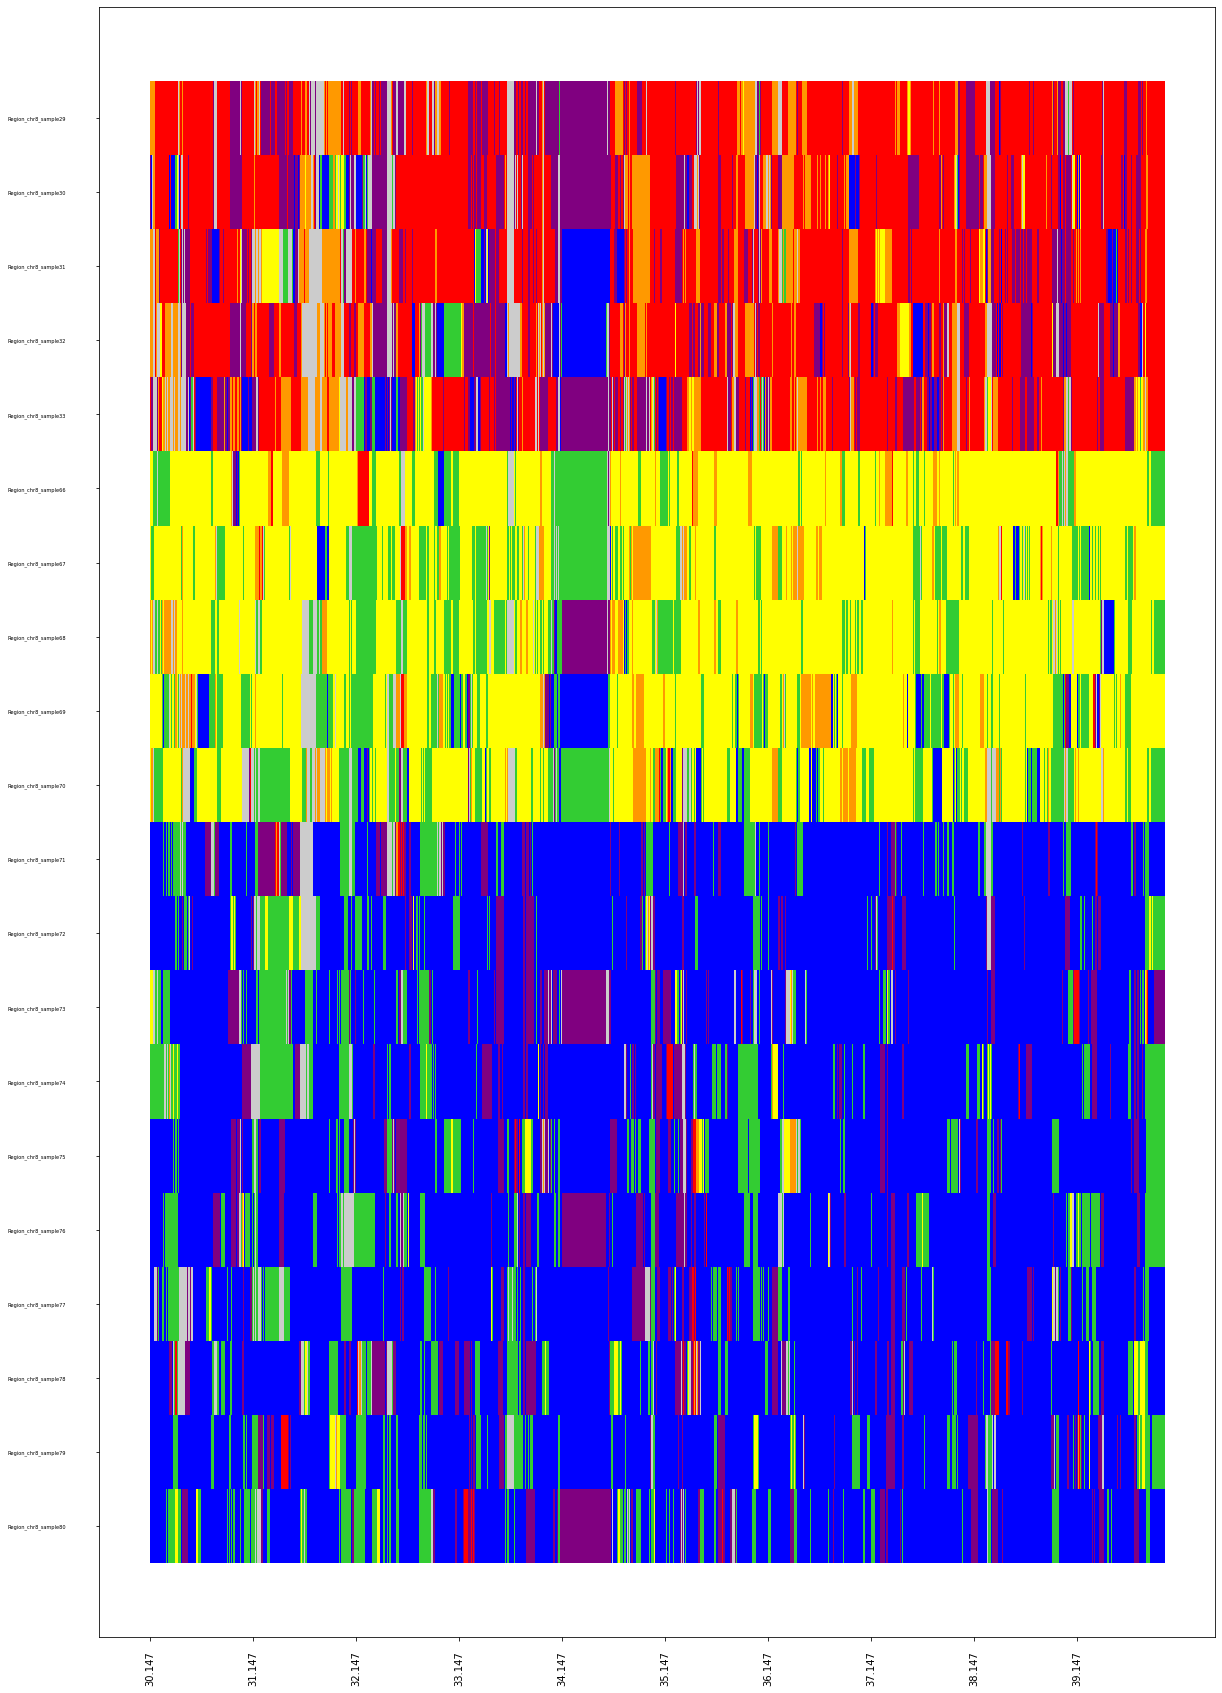

In [83]:
ID= 'kde_gp{}_w{}_N{}_M{}_th{}'.format('-'.join([str(x) for x in groups_plot]),Sn,Sm,window_size,Comparison_threshold)  


Fig_ideo= return_ideogram(ideo_kde,chromosome_list,ID,height= 30,width= 20)


### MeanShift cluster analysis

Parse and visualize local patterns of structure. 

We tackle the problem of identifying and comparing data structure across a great number of data sets. 

To begin, we perform mean shift and extract the respective sample *p*-values for the resulting clusters across local genomic windows.

We then analyse variation in *p*-value variation as it relates to the genetic strucures above, and study the average likelihood of individual samples within groups of similar clusters.


#### i. Cluster KDE


In [84]:
from structure_tools.StructE_tools import findPhiPT, Structure_profiles, Distance_profiles

from structure_tools.AMOVA_func import amova_cofactor, AMOVA_FM42
from structure_tools.mstutorial_tools import Windows_KDE_amova

### Perform Distance and association analysis on the data sets generated

### Define reference and admixed associations:
### for the purpose of this analysis exploration will be driven by
### structure distance profiles. Since KDE will be used for exploration, 
### a set of accessions can be analysed that do not contribute to 
### distance profiles.


##
ref_labels= [0,1,2]

refs_lib= {
    z: ref_dict[z] for z in ref_labels
}

KDE_comps= 4
clsize= 15
Bandwidth_split= 20

Results, Construct, PC_var= Windows_KDE_amova(Windows,
                                              ref_dict,
                                              refs_lib,
                                              supervised= True,
                                              amova= True,
                                              ncomps= KDE_comps,
                                              clsize= clsize,
                                              Bandwidth_split= Bandwidth_split)

chr 8, where: 3989483, supervised: True, n clusters: 3
old: ; jaccard: -0.016346358342161412; PCA euc: -0.003294041794317897; nHam: 0.06710770516165675


#### ii. Cluster variation.



In [85]:
Names=['id' + str(x) for x in range(len(Names))]
Fam= {
    Names[x]:x for x in range(len(Names))
}

Fam.update({
    x:Names[x] for x in range(len(Names))
})

###
Dr_dim= 4

###
focus_subset= False
Geneo= refs_lib
Focus_group= 0

Focus= [Names[x] for x in Geneo[Focus_group]]

###
Dr_var= 'all'
target_var= [0]

##


Chose clustering method and parameters to apply to cluster data in feature space. Individual sample *p*-values will be average across clusters falling in the same group. 

In [86]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

Method= 'Kmeans'

Cl_store= {
    'MeanShift':{
        'Clusterfunc': MeanShift,
        'cluster_kwargs': {
            'bin_seeding': False,
            'cluster_all': False,
            'min_bin_freq': 10
        }
    },
    'DBscan':{
        'Clusterfunc': DBSCAN,
        'cluster_kwargs': {
            'min_samples': 15
        }
    },
    'Ward':{
        'Clusterfunc': AgglomerativeClustering,
        'cluster_kwargs': {
            'linkage': 'ward',
            'n_clusters': 4
        }
    },
    'Kmeans':{
        'Clusterfunc': KMeans,
        'cluster_kwargs': {
            'random_state': 0,
            'n_clusters': 8
        }
    }
}



In [87]:
from structure_tools.mstutorial_tools import MAC_process


preProc_Clover, Cameo, Coordinates, COMPS, X_se, label_select, Subset, labels1= MAC_process(Construct,
                                                                             Out,
                                                                             Cl_store,
                                                                             refs_lib,
                                                                             Fam,
                                                                             Names= Names,
                                                                             target_var= target_var,
                                                                             Dr_var= Dr_var,
                                                                             focus_subset= focus_subset,
                                                                             Focus= Focus,
                                                                             Dr_dim= Dr_dim,
                                                                            threshold= .1,
                                                                             Method= Method)


Coordinates['label']= labels1

ValueError: Empty data passed with indices specified.

## 

In [88]:
from plotly import tools
from structure_tools.mstutorial_tools import KDE_pca

KDE_pca(feats= feats,Cameo= Cameo,label_vector= ref_vector,Subset= Subset,Col_vec= color_groups,height= 1200,width= 900)

NameError: name 'Cameo' is not defined

### iii. Plot cluster assigment by group

Plot cluster assignment of local haplotypes by physical position and genome of assignment.

Select groups of clusters to plot significance to using `select_label`. Assign group color in RGB using the `Colors`dictionary. Chose genomes across which to plot significance using `plot_who`. 

13684
adding ideograms...


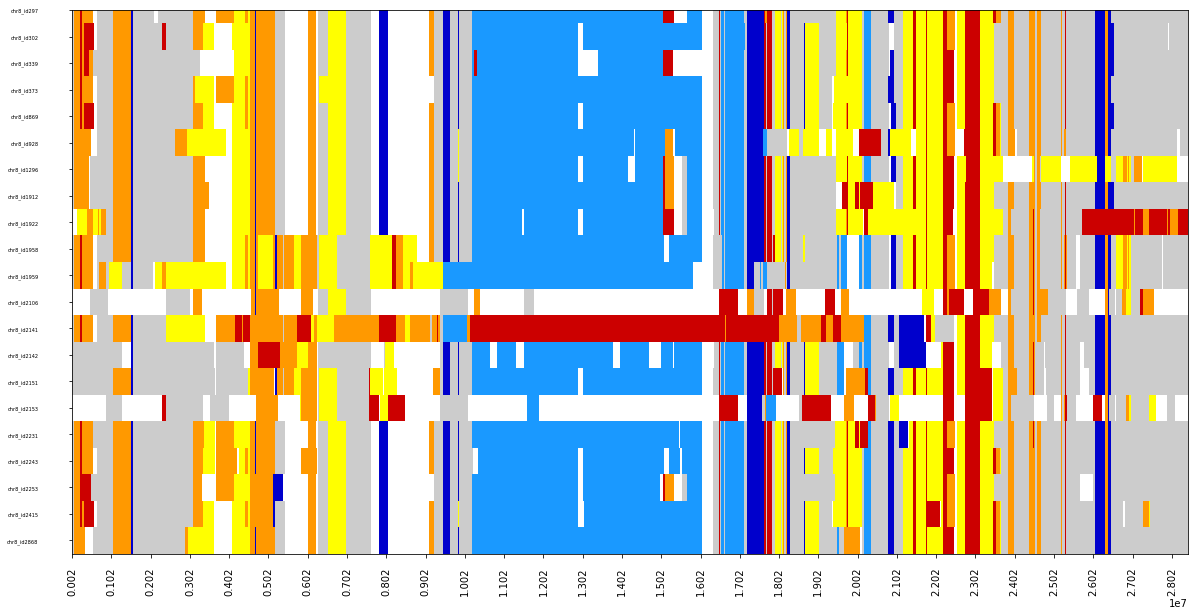

In [133]:
#from structure_tools.targeted_tools import mpl_target_ideo, chromosome_collections

select_label= [3,4,5,7,8]

Chr= 8
plot_tool= 'mpl'

plot_who= [3]

order= list(it.chain(*[ref_dict[x] for x in plot_who]))
#order= list(range(len(Nsample)))
names_sample= [Names[x] for x in Nsample]
#names_sample= [names_sample[x] for x in order]

Colors= {
    -1: [192,192,192],
    1: [139,0,0],
    3: [205,0,0],
    4: [255,255,0],
    5: [30,144,255],
    6: [0,0,255],
    7: [0,0,205],
    8: [255,165,0],
    9: [255,0,0],
    2: [0,0,0]
}

if plot_tool== 'plotly':

    Colors= {
        x: 'rgba(' + ','.join([str(z) for z in Colors[x]]) + ',1)' for x in Colors.keys()
    }

    target_ideogram(select_label,Coordinates,IDs,Colors=Colors,Chr= Chr,background= False,height_chrom= .5,height= 10,width= 5)

if plot_tool== 'mpl':
    
    background= True
    ideo_height= 1
    ideo_spacing= 0
    height= 10
    width= 20
    
    xticks= 1e6
    fig_save= True
    fig_id= 'ideo_target_gp{}'.format('.'.join([str(x) for x in plot_who]))
    Home= ''

    mpl_target_ideo(select_label,
                    Coordinates,
                    names_sample,
                    order= order,
                    background= True,
                    Chr= Chr,
                    ideo_height= ideo_height,
                    ideo_spacing= ideo_spacing,
                    xticks= xticks,
                    fig_save= fig_save,
                    fig_id= 'ideo_target',
                    Colors= Colors,
                    height= height,
                    width= width,
                   Home= Home)

